## Зависимостный парсинг (Dependency parsing)

Зависимостный парсинг - одна из немногих задач, где лингвистика и компьютерные науки продуктивно взаимодействуют. Основную теорию тут разрабатывают лингвисты, они же размечают корпусы, а модели построены на самых последних разробтах в области машинного обучения.

Так как теория и модели уже очень сложные, сделать что-то самому сопоставимого качества у вас вряд ли получится. Скорее всего вы ничего не будете обучать, а будет использовать готовые инструменты.

Самые популярных:
    
**Syntaxnet (DRAGNN)** - от гугла
    
**UDPipe** - от Карлова Университета в Чехии
    
SyntaxNet активно развивается, но его достаточно трудоемко ставить. 
UdPipe работает похуже, но установить его легче.

**TurkuNLP** - от университета Турку (это Финляндия). Позиционируется он как парсер для финского, но там есть много других предобученных моделей и можно обучать свои. 


Если вам нужен английский, то удобнее всего разбирать предложения через **spacy**.

Ещё есть **MaltParser**: http://www.maltparser.org/

Где прочитать про алгоритмы если вдруг интересно:

-работа про DRAGNN:
https://arxiv.org/abs/1703.04474

-работа про UDPIPE:
http://www.aclweb.org/anthology/K/K17/K17-3009.pdf



Основные исследования построены на Universal Dependcies (стандарт разметки отношений, объединяющий большое количество языков).

    
Сайт Universal dependencies приводит ссылки на доступные корпуса (там уже много языков):
http://universaldependencies.org/

Для русского стандартный корпус - Syntagrus:
https://github.com/UniversalDependencies/UD_Russian-SynTagRus

И не так давно выпустился корпус Taiga:
https://tatianashavrina.github.io/taiga_site/

На них можно обучать и тестрировать модели.

Большой размеченный UDPipe русскоязычный (и не только) корпус можно взять тут (острожно 24 гб в сжатом виде):
https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-1989

Вот тут описание типов отношений в UD:
http://universaldependencies.org/u/dep/

## Для чего можно использовать зависимости?

In [19]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
from collections import Counter
import numpy as np
import re
import warnings
import os
warnings.filterwarnings('ignore')

Посмотрим, как выглядит разобранное предложение. Я взял маленький кусочек корпуса Тайга (Arzamas) - скачать его можно тут - https://linghub.ru/static/Taiga/Arzamas.zip

В нем есть папка с обработанными текстами. Соберем их в один список.

In [20]:
path = 'Arzamas/texts_tagged/'
files = [path+file for file in os.listdir(path)]

In [21]:
files[1]

'Arzamas/texts_tagged/arzamas_232.txt'

Посмотрим, что лежит в этих файлах.

In [63]:
file = open(files[0]).read()

Разобранные предложения хранятся в формате CONLL (слово на каждой строчке, тэги через табы, предложения отделены двойными отступами)

In [64]:
tree = [x for x in file.split('\n\n')[0].split('\n')]

Перед разбором ещё может быть указана метаинформация (начало дока, параграфа, номер предложения, само предложения в изначальном виде).

In [65]:
tree

['# text = # newpar',
 '# sent_id = 1915',
 '# text = "Я люблю богемных писателей: Фицджеральд, этот парень, который покончил жизнь самоубийством...',
 '1\t"\t"\tPUNCT\t_\t_\t2\tpunct\t_\tSpaceAfter=No',
 '2\tЯ\tя\tPRON\t_\tCase=Nom|Number=Sing|Person=1\t3\tnsubj\t_\t_',
 '3\tлюблю\tлюбить\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_',
 '4\tбогемных\tбогемный\tADJ\t_\tAnimacy=Anim|Case=Acc|Degree=Pos|Number=Plur\t5\tamod\t_\t_',
 '5\tписателей\tписатель\tNOUN\t_\tAnimacy=Anim|Case=Acc|Gender=Masc|Number=Plur\t3\tobj\t_\tSpaceAfter=No',
 '6\t:\t:\tPUNCT\t_\t_\t5\tpunct\t_\t_',
 '7\tФицджеральд\tФицджеральд\tPROPN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t5\tnsubj\t_\tSpaceAfter=No',
 '8\t,\t,\tPUNCT\t_\t_\t7\tpunct\t_\t_',
 '9\tэтот\tэтот\tDET\t_\tCase=Nom|Gender=Masc|Number=Sing\t10\tamod\t_\t_',
 '10\tпарень\tпарень\tNOUN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t3\tappos\t_\tSpaceAfter=No',
 '11\t,\t,\tPUNCT\t_\

Но нам она не нужна. Соберем в один список все деревья.

In [42]:
trees = []

for file in files:
    parsed_sents = open(file).read().split('\n\n')
    
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))
        

In [43]:
trees[0]

'1\t"\t"\tPUNCT\t_\t_\t2\tpunct\t_\tSpaceAfter=No\n2\tЯ\tя\tPRON\t_\tCase=Nom|Number=Sing|Person=1\t3\tnsubj\t_\t_\n3\tлюблю\tлюбить\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tбогемных\tбогемный\tADJ\t_\tAnimacy=Anim|Case=Acc|Degree=Pos|Number=Plur\t5\tamod\t_\t_\n5\tписателей\tписатель\tNOUN\t_\tAnimacy=Anim|Case=Acc|Gender=Masc|Number=Plur\t3\tobj\t_\tSpaceAfter=No\n6\t:\t:\tPUNCT\t_\t_\t5\tpunct\t_\t_\n7\tФицджеральд\tФицджеральд\tPROPN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t5\tnsubj\t_\tSpaceAfter=No\n8\t,\t,\tPUNCT\t_\t_\t7\tpunct\t_\t_\n9\tэтот\tэтот\tDET\t_\tCase=Nom|Gender=Masc|Number=Sing\t10\tamod\t_\t_\n10\tпарень\tпарень\tNOUN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t3\tappos\t_\tSpaceAfter=No\n11\t,\t,\tPUNCT\t_\t_\t10\tpunct\t_\t_\n12\tкоторый\tкоторый\tPRON\t_\tCase=Nom\t13\tnsubj\t_\t_\n13\tпокончил\tпокончить\tVERB\t_\tAspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|

In [66]:
[x.replace('\t', ' ') for x in trees[2].split('\n')]

['1 Некоторые некоторый DET _ Case=Nom|Number=Plur 3 nsubj _ _',
 '2 были быть VERB _ Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 3 cop _ _',
 '3 алкоголиками алкоголик NOUN _ Animacy=Inan|Case=Ins|Gender=Masc|Number=Plur 0 root _ _',
 '4 и и CCONJ _ _ 5 cc _ _',
 '5 наркоманами наркоман NOUN _ Animacy=Inan|Case=Ins|Gender=Masc|Number=Plur 3 conj _ SpaceAfter=No',
 '6 , , PUNCT _ _ 5 punct _ _',
 '7 но но CCONJ _ _ 9 cc _ _',
 '8 классно классно ADV _ Degree=Pos 9 advmod _ _',
 '9 проводили проводить VERB _ Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 3 conj _ _',
 '10 время время NOUN _ Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing 9 obj _ SpaceAfter=No',
 '11 . . PUNCT _ _ 10 punct _ _']

В nltk есть удобный класс для загрузки таких деревьев:

In [83]:
d = DependencyGraph(trees[10])

Все хранится в словаре словарей. Первый словарь - индексы слов, а дальше находится разная лингвистическая информация.

In [130]:
d.nodes

По названию класса можно понять, что это граф. Из графа соответственно можно достать узлы и ребра.

У объекта есть метод triples, который достает все узлы.

In [81]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'root', ('люблю', 'VERB')),
 (('люблю', 'VERB'), 'nsubj', ('Я', 'PRON')),
 (('Я', 'PRON'), 'punct', ('"', 'PUNCT')),
 (('люблю', 'VERB'), 'obj', ('писателей', 'NOUN')),
 (('писателей', 'NOUN'), 'amod', ('богемных', 'ADJ')),
 (('писателей', 'NOUN'), 'punct', (':', 'PUNCT')),
 (('писателей', 'NOUN'), 'nsubj', ('Фицджеральд', 'PROPN')),
 (('Фицджеральд', 'PROPN'), 'punct', (',', 'PUNCT')),
 (('люблю', 'VERB'), 'appos', ('парень', 'NOUN')),
 (('парень', 'NOUN'), 'amod', ('этот', 'DET')),
 (('парень', 'NOUN'), 'punct', (',', 'PUNCT')),
 (('парень', 'NOUN'), 'acl:relcl', ('покончил', 'VERB')),
 (('покончил', 'VERB'), 'nsubj', ('который', 'PRON')),
 (('покончил', 'VERB'), 'xcomp', ('самоубийством.', 'VERB')),
 (('самоубийством.', 'VERB'), 'obj', ('жизнь', 'NOUN')),
 (('самоубийством.', 'VERB'), 'punct', ('.', 'PUNCT')),
 (('самоубийством.', 'VERB'), 'punct', ('.', 'PUNCT'))]

Что с этим можно сделать?

Можно использовать полученные деревья для анализа корпуса. 

### Задание 1. 
Пройдитесь по корпусу, преобразуя дерево в такие же кортежи как и в ячейке выше. Достаньте все модификаторы слов 'парень' и 'девушка'.

In [ ]:
modifiers = ...
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    # ваш код здесь
    

Одно слова может быть недостаточно. Отношение часто указывает на главное слово в какой-то именной группе, а от него отходят отношения к другим её составляющим. Мы можем захотеть пройтись по всем ответвлениям, чтобы собрать всю именную группу. 

Удобнее всего это сделать через рекурсию. Напишем функцию, котороя проходит по всем зависимым конкретного узла в дереве и достает их зависимые, пока не упрется в терминальный узел.

### Задание 2.  

Напишите рекурсивную функцию, которая преобразуется список с вложенностью в простой список чисел.

In [67]:
a = [1, 2, [3, 4], [[5], [6, 7]]]

In [72]:
# должно получиться [1, 2, 3, 4, 5, 6, 7]

In [ ]:
def flatten_list(l):
    
    if stopping_criteria:
        return ...
    else:
        flatten_list

Теперь вы лучше будете понимать, что происходит в этой функции.

In [77]:
def get_subtree(nodes, node):
    
    
    if not nodes[node]['deps']:
        return [node]
    
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] 
                         if rel != 'punct'  # пунктуацию доставать не будем
                         for dep in nodes[node]['deps'][rel]]



Дерево можно нарисовать через networkx, чтобы лучше понимать какие поддеревья мы хотим достать.

In [101]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 

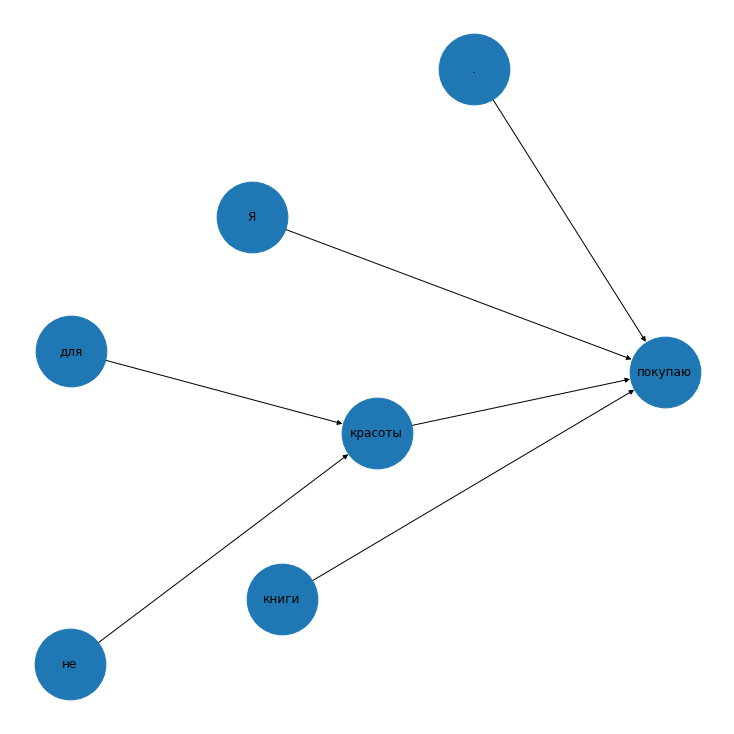

In [122]:
plt.figure(figsize=(10,10))
nx.draw(d.nx_graph(), labels=d.nx_labels, node_size=5000)

In [114]:
d.nx_labels

{1: 'Я', 2: 'книги', 3: 'не', 4: 'для', 5: 'красоты', 6: 'покупаю', 7: '.'}

Достанем все поддерево какого-нибудь элемента.

In [124]:
get_subtree(d.nodes, 6)

[6, [1], [2], [5, [3], [4]]]

Получается список с вложенными списками. Чтобы представить это все в читаемом формате лучше его раплющить ещё одной рекурсивной функцией (такой как мы написали выше). 

In [125]:
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [126]:
flatten(get_subtree(d.nodes, 5))

[5, 3, 4]

Проверим, что досталось.

In [127]:
[d.nodes[i]['word'] for i in flatten(get_subtree(d.nodes, 5))]

['красоты', 'не', 'для']

Нужно ещё восстановить порядок.

In [128]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 5)))]

['не', 'для', 'красоты']

In [129]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 5)))]

['не', 'для', 'красоты']

### Задание 3.

Попробуйте теперь также пройтись по корпусу, найти глаголы и если у этих глаголов есть **nsubj** и **obj** (или **obl**), то достать всё поддерево для них.

Результат должен выглядеть как-то так:
    ('Субъект', 'глагол', 'объект')

In [ ]:
# ваш код здесь
...
...


### Использование для других задач

Ещё зависимости можно использовать в качестве признаков для классификации или кластеризации.

Допустим мы хотим научиться выделять отношения между существительными. Мы можем пройтись по корпусу, достать все фразы, а потом достать из графа самый короткий путь, соединящию эти фразы.

Дальше путь можно каким-то образом преобразовать в векторы и напрмую засовывать в классификатор или кластеризатор. 

In [30]:
# поиск самого короткого пути есть в networkx
import networkx as nx

In [36]:

dg = DependencyGraph(trees[123])
edges = []

for e in dg.nodes:
    for dep in dg.nodes[e]['deps']:
        for t in dg.nodes[e]['deps'][dep]:
            edges.append((e, t))




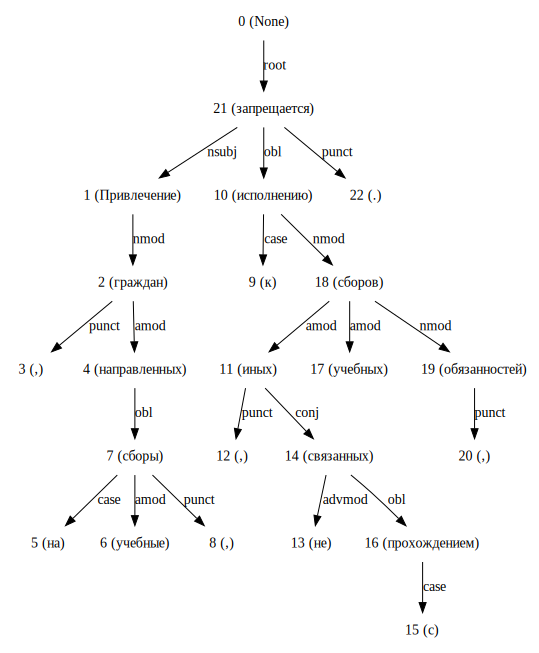

In [38]:
dg

In [37]:
edges

[(0, 21),
 (1, 2),
 (2, 3),
 (2, 4),
 (4, 7),
 (7, 5),
 (7, 8),
 (7, 6),
 (10, 9),
 (10, 18),
 (11, 12),
 (11, 14),
 (14, 16),
 (14, 13),
 (16, 15),
 (18, 19),
 (18, 11),
 (18, 17),
 (19, 20),
 (21, 10),
 (21, 1),
 (21, 22)]

In [39]:
graph = nx.Graph()
graph.add_edges_from(ebunch=edges)

In [40]:
nx.shortest_path(graph, 1, 10)

[1, 21, 10]

Ещё с помощью деревьев завимимостей можно находить похожие по структуре предложения. Похожесть графов не тривиальная проблема, но кое-что готовое есть.

Например, есть библиотека zss (https://github.com/timtadh/zhang-shasha), которая реализует алгоритм редактирования деревьев (примерно как с Левенштейном, но с учетом структуры дерева).

По умолчанию разница высчитывается на основе расстояния между названиями узлов и для своих задач её лучше переопределить.

In [4]:
import zss
import re

In [6]:
# эта функция достает поддерво элементов
# c дополнительной информацией и возвращает
# все в нужном zss формате

def subtree(node, tree):
    if not tree[node]['deps']:
        word = tree[node]['word'].replace("'", '"')
        
        if not word:
            word = 'UNK'
        pos = tree[node]['ctag'].replace("'", '"')
        rel = tree[node]['rel'].replace("'", '"')
        label = 'WORD=#{}#,POS=#{}#,REL=#{}#'.format(word, pos, rel)
        return "WNode('{}', [])".format(label)
    else:
        sub = []
        for dep in tree[node]['deps']:
            for n in tree[node]['deps'][dep]:
                sub.append(subtree(n, tree))
        
        if not tree[node]['rel']:
            if tree[node]['ctag'] == 'TOP':
                name = 'TOP'
                word = 'TOP'
                if not word:
                    word = 'UNK'
                pos = 'TOP'
                rel = 'TOP'
            else:
                print('Node numeber - {} is None and not TOP!'.format(node))
                raise KeyError
        else:    
            word = tree[node]['word'].replace("'", '"')
            pos = tree[node]['ctag'].replace("'", '"')
            rel = tree[node]['rel'].replace("'", '"')
        label = 'WORD=#{}#,POS=#{}#,REL=#{}#'.format(word, pos, rel)
            
        return "WNode('{}', [{}])".format(label , ', '.join(sub))


# функция раастояния для деревьев

def weird_dist(A, B):
    ma = re.search('WORD=#(.*?)#,POS=#(.*?)#,REL=#(.*?)#', A)
    mb = re.search('WORD=#(.*?)#,POS=#(.*?)#,REL=#(.*?)#', B)
    
    # для удаления 
    if not ma and mb: # сколько стоит добавление узла
        return 1
    elif ma and not mb: # сколько стоит удаление узла
        return 3
    elif not ma and not mb:
        return 0
    
    # для расчета расстояния можно учитывать само слов
    # часть речи, отношение и любую другую информацию
    
    word_a, pos_a, rel_a = ma.groups()
    word_b, pos_b, rel_b = mb.groups()
    
    
    dist = 0
    
    
    if word_a != word_b:
        dist += 1
    
    if pos_a != pos_b:
        dist += 1
    
    if rel_a != rel_b:
        dist += 1
    
    
    return dist

# специальный класс для zss
class WNode(object):

    def __init__(self, label, children=None):
        self.my_label = label
        self.my_children = children or list()

    @staticmethod
    def get_children(node):
        return node.my_children

    @staticmethod
    def get_label(node):
        return node.my_label

    def addkid(self, node, before=False):
        if before:  self.my_children.insert(0, node)
        else:   self.my_children.append(node)
        return self
    
    def __str__(self):
        s = "%d:%s" % (len(self.my_children), self.my_label)
        s = '\n'.join([s]+[str(c) for c in self.my_children])
        return s



In [7]:
A = eval(subtree(0, DependencyGraph(trees[123]).nodes))
B = eval(subtree(0, DependencyGraph(trees[1223]).nodes))
print(zss.simple_distance(A, B, WNode.get_children, 
                                   WNode.get_label, weird_dist))

63


Посравниваем деревья.

In [8]:
distances = []
for i in range(0, 500):
    
    
    try:
        A = eval(subtree(0, DependencyGraph(trees[i]).nodes))
        print(i)
        for j in np.random.choice(range(len(trees)), 100):
            B = eval(subtree(0, DependencyGraph(trees[j]).nodes))
            dist = zss.simple_distance(A, B, WNode.get_children, 
                                       WNode.get_label, weird_dist)
            distances.append((i, j, dist))
    except TypeError:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

Посмотрим, что нашлось.

In [131]:
# sorted(distances, key=lambda x: x[2])

In [26]:

[x.replace('\t', ' ') for x in trees[0].split('\n')]

['1 Панихиду Панихида VERB _ Aspect=Perf|Mood=Ind|Number=Sing|Person=1|Tense=Fut|VerbForm=Fin|Voice=Act 0 root _ _',
 '2 по по ADP _ _ 3 case _ _',
 '3 жертвам жертва NOUN _ Animacy=Anim|Case=Dat|Gender=Fem|Number=Plur 1 obl _ _',
 '4 трагедии трагедия NOUN _ Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing 3 nmod _ SpaceAfter=No',
 '5 , , PUNCT _ _ 4 punct _ _',
 '6 произошедшей произоходить VERB _ Aspect=Perf|Case=Loc|Gender=Fem|Number=Sing|Tense=Past|VerbForm=Part|Voice=Act 3 amod _ _',
 '7 в в ADP _ _ 8 case _ _',
 '8 Одессе одесса PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing 6 obl _ _',
 '9 2 2 NUM _ _ 6 nummod _ _',
 '10 мая май NOUN _ Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing 9 nmod _ SpaceAfter=No',
 '11 , , PUNCT _ _ 10 punct _ _',
 '12 отслужили отслуживать VERB _ Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 1 parataxis _ _',
 '13 в в ADP _ _ 14 case _ _',
 '14 воскресенье воскресенье NOUN _ Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing 12 obl _ 

In [27]:
# Как выглядит его дерево
[x.replace('\t', ' ') for x in trees[9371].split('\n')]

['1 ЗАСО ЗАСО ADP _ _ 3 case _ _',
 '2 " " PUNCT _ _ 3 punct _ SpaceAfter=No',
 '3 Белнефтестрах Белнефтестра PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Plur 0 root _ SpaceAfter=No',
 '4 " " PUNCT _ _ 3 punct _ _',
 '5 - - PUNCT _ _ 3 punct _ _',
 '6 Высококачественное высококачественный ADJ _ Case=Nom|Degree=Pos|Gender=Neut|Number=Sing 7 amod _ _',
 '7 страхование страхование NOUN _ Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing 3 parataxis _ _',
 '8 для для ADP _ _ 12 case _ _',
 '9 физических физический ADJ _ Case=Gen|Degree=Pos|Number=Plur 12 amod _ _',
 '10 и и CCONJ _ _ 11 cc _ _',
 '11 юридических юридический ADJ _ Case=Gen|Degree=Pos|Number=Plur 9 conj _ _',
 '12 лиц лицо NOUN _ Animacy=Anim|Case=Gen|Gender=Neut|Number=Plur 7 nmod _ _',
 '13 в в ADP _ _ 14 case _ _',
 '14 Беларуси Беларусь PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing 12 nmod _ _']

In [58]:
WNode('WORD=#TOP#,POS=#TOP#,REL=#TOP#', [WNode('WORD=#презентовала#,POS=#VERB#,REL=#root#', [WNode('WORD=#Компания#,POS=#PROPN#,REL=#nsubj#', [WNode('WORD=#ИНТРА»#,POS=#PROPN#,REL=#flat:name#', []), WNode('WORD=#«Сервисная#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#21#,POS=#NUM#,REL=#nummod#', [WNode('WORD=#-#,POS=#PUNCT#,REL=#punct#', []), WNode('WORD=#июня#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#ООО#,POS=#PROPN#,REL=#nmod#', [])]), WNode('WORD=#22#,POS=#NUM#,REL=#nummod#', [])]), WNode('WORD=#технологии#,POS=#NOUN#,REL=#obj#', [WNode('WORD=#ремонта#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#композитного#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#конференции#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#на#,POS=#ADP#,REL=#case#', []), WNode('WORD=#ТРУБОПРОВОДЫ#,POS=#PROPN#,REL=#appos#', [WNode('WORD=#'2016#,POS=#X#,REL=#flat:foreign#', []), WNode('WORD=#ПРОМЫСЛОВЫЕ#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#5-ой#,POS=#ADJ#,REL=#amod#', []), WNode('WORD=#Ежегодной#,POS=#ADJ#,REL=#amod#', []), WNode('WORD=#технической#,POS=#ADJ#,REL=#amod#', [WNode('WORD=#производственно#,POS=#ADJ#,REL=#compound#', [WNode('WORD=#-#,POS=#PUNCT#,REL=#punct#', [])])])])])])])

In [59]:
dist

66